# Math 395 Miniproject 3 (Neural nets)

Hope College, Fall 2024

Import libraries

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import scipy.io

# import accuracyScore
from sklearn.metrics import accuracy_score

# add more libraries here

## (1) Display the dicision boundary of a neural network

Train several neural networks on the twomoons data and display their decision boundaries

In [2]:
mat = scipy.io.loadmat('../datasets/twomoons.mat')

X_train = mat['X']
y_train = mat['truelabels']

## (2) Fully connected neural networks

Train a neural network using the training images in the fashion mnist data set and evaluate the network on the test data. Try to play with the hyperparameters of the network, such as 

- number of layers, 
- number of neurons on each layer, 
- activation function,
- regularization parameter, and
- batch size

What is the lowest test error you can achieve?

In [3]:
mat = scipy.io.loadmat('../datasets/fashion.mat')

X_train = mat['Xtr']
y_train = mat['ytr']
X_test = mat['Xtst']
y_test = mat['ytst']

In [14]:
import numpy as np
from concurrent.futures import ThreadPoolExecutor

class Network(object):
    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        if test_data:
            n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            np.random.shuffle(training_data)
            mini_batches = [
                training_data[k:k + mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print(f"Epoch {j}: {self.evaluate(test_data)} / {n_test}")
            else:
                print(f"Epoch {j} complete")

    def update_mini_batch(self, mini_batch, eta):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w - (eta / len(mini_batch)) * nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - (eta / len(mini_batch)) * nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        activation = x
        activations = [x]
        zs = []
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        delta = self.cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l + 1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l - 1].transpose())
        return nabla_b, nabla_w

    def evaluate(self, test_data):
        test_results = [(np.argmax(self.feedforward(x)), y) for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        return output_activations - y

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z) * (1 - sigmoid(z))

In [15]:
training_data = [(x.reshape(-1, 1), y) for x, y in zip(X_train, y_train)]
test_data = [(x.reshape(-1, 1), y) for x, y in zip(X_test, y_test)]

In [16]:
# Use multiple loops to try different hyperparameters
layers = [[784, 30, 10], [784, 30, 30, 10], [784, 30, 30, 30, 10], [784, 30, 30, 30, 30, 10], [784, 30, 30, 30, 30, 30, 10]]
batch_sizes = [10, 50, 100, 500]
etas = [0.01, 0.1, 0.5, 1.0]
epochs = 30

In [ ]:
# Parallelize the outer loop
results = []

def run_network(layer, batch_size, eta, training_data, epochs, test_data):
    net = Network(layer)
    net.SGD(training_data, epochs, batch_size, eta, test_data=test_data)
    print(f"Layers: {layer}, Batch size: {batch_size}, Eta: {eta}\n\n")
    accuracy = net.evaluate(test_data) / len(test_data)
    test_error = 1 - accuracy
    return (layer, batch_size, eta, test_error)

with ThreadPoolExecutor() as executor:
    futures = []
    for layer in layers:
        for batch_size in batch_sizes:
            for eta in etas:
                futures.append(executor.submit(run_network, layer, batch_size, eta, training_data, epochs, test_data))
    
    for future in futures:  
        results.append(future.result())

/var/folders/cn/2914x2w5213cm0p8fp564wfm0000gn/T/ipykernel_28787/2558099508.py:74: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))
/var/folders/cn/2914x2w5213cm0p8fp564wfm0000gn/T/ipykernel_28787/2558099508.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return sum(int(x == y) for (x, y) in test_results)


Epoch 0: 927 / 10000
Epoch 0: 906 / 10000
Epoch 0: 373 / 10000
Epoch 0: 683 / 10000
Epoch 0: 1742 / 10000
Epoch 0: 1016 / 10000
Epoch 0: 930 / 10000
Epoch 0: 723 / 10000
Epoch 0: 757 / 10000
Epoch 0: 780 / 10000
Epoch 0: 927 / 10000
Epoch 0: 1211 / 10000
Epoch 1: 950 / 10000
Epoch 1: 421 / 10000
Epoch 1: 713 / 10000
Epoch 1: 927 / 10000
Epoch 1: 908 / 10000
Epoch 1: 1725 / 10000
Epoch 1: 704 / 10000
Epoch 1: 984 / 10000
Epoch 1: 1197 / 10000
Epoch 1: 703 / 10000
Epoch 1: 770 / 10000
Epoch 1: 959 / 10000
Epoch 2: 720 / 10000
Epoch 2: 945 / 10000
Epoch 2: 974 / 10000
Epoch 2: 465 / 10000
Epoch 2: 945 / 10000
Epoch 2: 1202 / 10000
Epoch 2: 927 / 10000
Epoch 2: 760 / 10000
Epoch 2: 1766 / 10000
Epoch 2: 689 / 10000
Epoch 2: 700 / 10000
Epoch 2: 1004 / 10000
Epoch 3: 735 / 10000
Epoch 3: 968 / 10000
Epoch 3: 475 / 10000
Epoch 3: 935 / 10000
Epoch 3: 1764 / 10000
Epoch 3: 937 / 10000
Epoch 3: 761 / 10000
Epoch 3: 694 / 10000
Epoch 3: 1194 / 10000
Epoch 3: 687 / 10000
Epoch 3: 942 / 10000
Epo

In [13]:
results = []

for layer in layers:
    for batch_size in batch_sizes:
        for eta in etas:
            net = Network(layer)
            net.SGD(training_data, epochs, batch_size, eta, test_data=test_data)
            print(f"Layers: {layer}, Batch size: {batch_size}, Eta: {eta}\n\n")
            accuracy = net.evaluate(test_data) / len(test_data)
            test_error = 1 - accuracy
            results.append((layer, batch_size, eta, test_error))

/var/folders/cn/2914x2w5213cm0p8fp564wfm0000gn/T/ipykernel_28787/1445281195.py:76: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))
/var/folders/cn/2914x2w5213cm0p8fp564wfm0000gn/T/ipykernel_28787/1445281195.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return sum(int(x == y) for (x, y) in test_results)


Epoch 0: 1042 / 10000
Epoch 1: 1043 / 10000
Epoch 2: 1029 / 10000


KeyboardInterrupt: 

## (3) Convolutional neural network on the fashion-mnist data

You can refer to the following webpage:

https://www.datacamp.com/tutorial/convolutional-neural-networks-python

You just need to copy all the code from there and reproduce the results below.

In [ ]:
from keras.datasets import fashion_mnist
(train_X,train_Y), (test_X,test_Y) = fashion_mnist.load_data()

In [ ]:
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt

print('Training data shape : ', train_X.shape, train_Y.shape)

print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (60000, 28, 28) (60000,)
Testing data shape :  (10000, 28, 28) (10000,)


In [ ]:
# Find the unique numbers from the train labels
classes = np.unique(train_Y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)


Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


In [ ]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))


Text(0.5, 1.0, 'Ground Truth : 9')

In [ ]:
from matplotlib.text import Text

Text(0.5, 1, u'Ground Truth : 9')

Text(0.5, 1, 'Ground Truth : 9')

In [ ]:
train_X = train_X.reshape(-1, 28,28, 1)
test_X = test_X.reshape(-1, 28,28, 1)
train_X.shape, test_X.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [ ]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.


In [ ]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])


Original label: 9
After conversion to one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [ ]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [ ]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

In [ ]:
import keras
from keras import Sequential,Model
from keras import Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU

In [ ]:
batch_size = 64
epochs = 20
num_classes = 10

In [ ]:
fashion_model = Sequential()
fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(28,28,1),padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D((2, 2),padding='same'))
fashion_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Flatten())
fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(Dense(num_classes, activation='softmax'))

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
fashion_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [ ]:
fashion_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,234 (1.36 MB)

 Trainable params: 356,234 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
fashion_train = fashion_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.7535 - loss: 0.6775 - val_accuracy: 0.8699 - val_loss: 0.3508
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.8899 - loss: 0.2994 - val_accuracy: 0.8974 - val_loss: 0.2777
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.9131 - loss: 0.2378 - val_accuracy: 0.8960 - val_loss: 0.2796
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.9225 - loss: 0.2085 - val_accuracy: 0.9153 - val_loss: 0.2353
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.9345 - loss: 0.1768 - val_accuracy: 0.9072 - val_loss: 0.2515
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.9395 - loss: 0.1615 - val_accuracy: 0.9133 - val_loss: 0.2546
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.9509 - loss: 0.1310 - val_accuracy: 0.9101 - val_loss: 0.2610
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.9570 - loss: 0.1170 - 

In [ ]:
test_eval = fashion_model.evaluate(test_X, test_Y_one_hot, verbose=0)

In [ ]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.494412899017334
Test accuracy: 0.9144999980926514


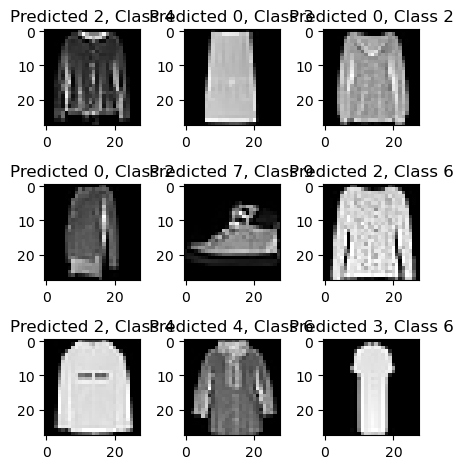

In [ ]:
plt.show()

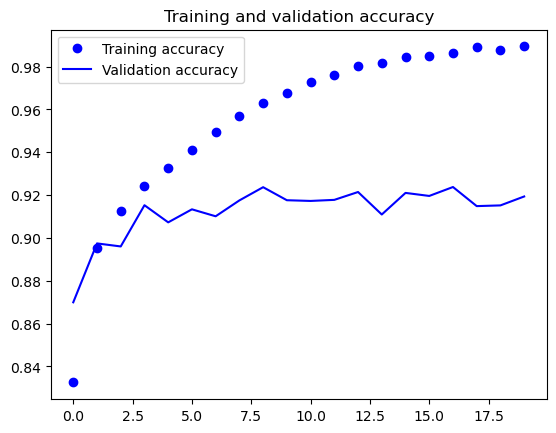

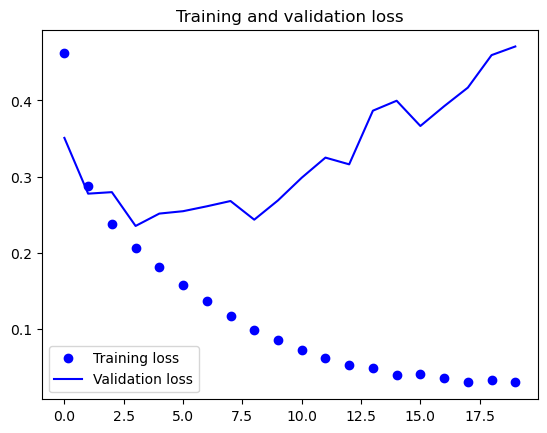

In [ ]:
accuracy = fashion_train.history['accuracy']
val_accuracy = fashion_train.history['val_accuracy']
loss = fashion_train.history['loss']
val_loss = fashion_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
batch_size = 64
epochs = 20
num_classes = 10

In [ ]:
fashion_model = Sequential()
fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(28,28,1)))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D((2, 2),padding='same'))
fashion_model.add(Dropout(0.25))
fashion_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Dropout(0.25))
fashion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Dropout(0.4))
fashion_model.add(Flatten())
fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.1))           
fashion_model.add(Dropout(0.3))
fashion_model.add(Dense(num_classes, activation='softmax'))

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
fashion_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,234 (1.36 MB)

 Trainable params: 356,234 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
fashion_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [ ]:
fashion_train_dropout = fashion_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 25s 33ms/step - accuracy: 0.6747 - loss: 0.8698 - val_accuracy: 0.8630 - val_loss: 0.3676
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.8535 - loss: 0.3994 - val_accuracy: 0.8841 - val_loss: 0.3145
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.8795 - loss: 0.3336 - val_accuracy: 0.8973 - val_loss: 0.2791
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.8881 - loss: 0.3038 - val_accuracy: 0.9009 - val_loss: 0.2626
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.8935 - loss: 0.2837 - val_accuracy: 0.9082 - val_loss: 0.2490
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.8998 - loss: 0.2701 - val_accuracy: 0.9103 - val_loss: 0.2431
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.9041 - loss: 0.2537 - val_accuracy: 0.9141 - val_loss: 0.2363
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - accuracy: 0.9078 - loss: 0.2460 - 

In [ ]:
fashion_model.save("fashion_model_dropout.keras")

In [ ]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.494412899017334
Test accuracy: 0.9144999980926514


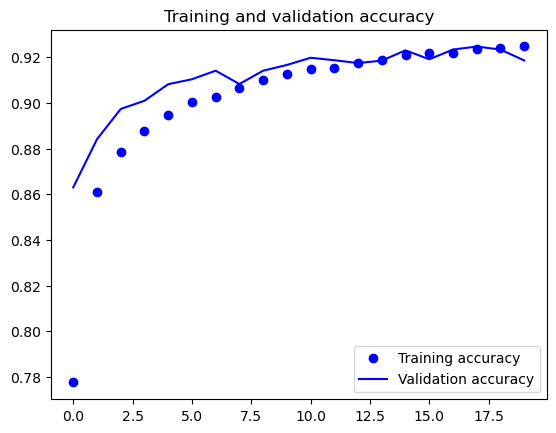

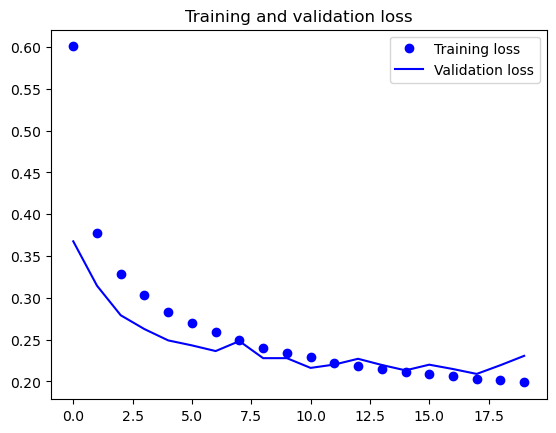

In [ ]:
accuracy = fashion_train_dropout.history['accuracy']
val_accuracy = fashion_train_dropout.history['val_accuracy']
loss = fashion_train_dropout.history['loss']
val_loss = fashion_train_dropout.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
predicted_classes = fashion_model.predict(test_X)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [ ]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [ ]:
predicted_classes.shape, test_Y.shape

((10000,), (10000,))

In [ ]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_Y[correct]))
    plt.tight_layout()

Found 9100 correct labels


In [ ]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_Y[incorrect]))
    plt.tight_layout()

Found 900 incorrect labels


In [ ]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.77      0.91      0.83      1000
     Class 1       1.00      0.98      0.99      1000
     Class 2       0.80      0.92      0.86      1000
     Class 3       0.93      0.92      0.93      1000
     Class 4       0.87      0.83      0.85      1000
     Class 5       1.00      0.96      0.98      1000
     Class 6       0.86      0.65      0.74      1000
     Class 7       0.95      0.98      0.96      1000
     Class 8       0.99      0.98      0.99      1000
     Class 9       0.96      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

